<a href="https://colab.research.google.com/github/NaNoN123/AltoTech_Internship_Test/blob/main/AltoTech_Test_Intership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**
Imagine you are a control engineer who is tasked with designing a controller for a chiller
plant with the objective of minimizing the total chiller power consumption over a
24-hour operating period, while ensuring the building’s cooling load is fully satisfied at all
times. The controller will receive a 24-hour forecast of the building’s cooling demand
(measured in tons) and historical operational data from the plant. The plant consists of
seven chillers, four 1000-Ton chillers (CH-1 to CH-4), two 500-Ton chillers (CH-6 and CH-7),
and one 250-Ton chiller (CH-8). The chilled water supply temperature (CHS) from each
chiller is assumed to perfectly track the controller’s setpoint, which must remain within the
range of 44 to 49  ̊F. The condenser water supply temperature (CDS) is fixed at 82  ̊F.
The system also includes operational timing constraints: chillers can only be turned ON
between 01:00 and 12:00, and can only be turned OFF between 12:00 and 22:00.
Furthermore, once a chiller is turned ON, it must remain ON for at least 4 consecutive
hours. In addition, it is required that the average CHS of 45  ̊F must be supplied to the
building at each hour.
Your controller’s task is to determine, for each hour of the day, the ON/OFF status of each
chiller and the CHS setpoint for each active chiller. The solution must adhere to all specified
constraints and aim to minimize the total energy consumed by the chillers throughout the
24-hour period.
You are expected to design the control strategy using your own modeling approach, based
on the data provided. The controller should respect all operational constraints while
minimizing total energy consumption across chillers and pumps.

##Import Data
## ⚠ Note: Upload file "dataset_for_chiller_control.cvs"
---
(Open item Files at left side and drag file "dataset_for_chiller_control.cvs" in to it)

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns
import cvxpy as cp

In [2]:
# @title
# Define the file path
file_path = "/content/dataset_for_chiller_control.csv"

# Dynamically build chiller list (skip chiller 5)
chillers = [f'chiller_{i}' for i in range(1, 9) if i != 5]

# Initialize data storage
chiller_data = {chiller: [] for chiller in chillers}
datetime_data = []
plant_data = []

# Open CSV file
with open(file_path, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)

    # Skip first 2 header rows
    header1 = next(reader)
    header2 = next(reader)
    none = next(reader)

    # Compute column indices dynamically (8 columns per chiller)
    chiller_columns = {}
    base_idx = 1  # first chiller starts from column 1
    for i in range(1, 9):
        if i == 5:
            continue  # skip chiller 5
        chiller_name = f'chiller_{i}'
        chiller_columns[chiller_name] = list(range(base_idx, base_idx + 8))
        base_idx += 8

    # Process data rows
    for row in reader:
        # Chiller data
        for chiller, cols in chiller_columns.items():
            data_row = [float(row[col]) if row[col] != '' else np.nan for col in cols]
            chiller_data[chiller].append(data_row)

        # Plant data (last 2 columns)
        plant_row = [float(row[-2]) if row[-2] != '' else np.nan,
                     float(row[-1]) if row[-1] != '' else np.nan]
        plant_data.append(plant_row)

        date_row = row[0]
        datetime_data.append(date_row)

# Convert to NumPy arrays
for chiller in chillers:
    chiller_data[chiller] = np.array(chiller_data[chiller])

plant_data = np.array(plant_data)


In [3]:
var_name = ['CDS',	'CDR',	'Ton',	'CHR',	'CHS',	'kW',	'Setpoint',	'On-Off']

In [4]:
# @title
processed_times = []

for time_str in datetime_data:
    # Parse the datetime string
    # We need to handle the timezone information.
    # The %z format code in strptime can parse timezone offsets like +07:00
    dt_object = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S%z')

    # Extract the hour and minute
    hour = dt_object.hour
    minute = dt_object.minute
    day = dt_object.day
    month = dt_object.month
    year = dt_object.year

    # Calculate the time as a float (hour + minute/60)
    time_float = day+hour/24.0 + minute / 60.0/24

    processed_times.append(time_float)

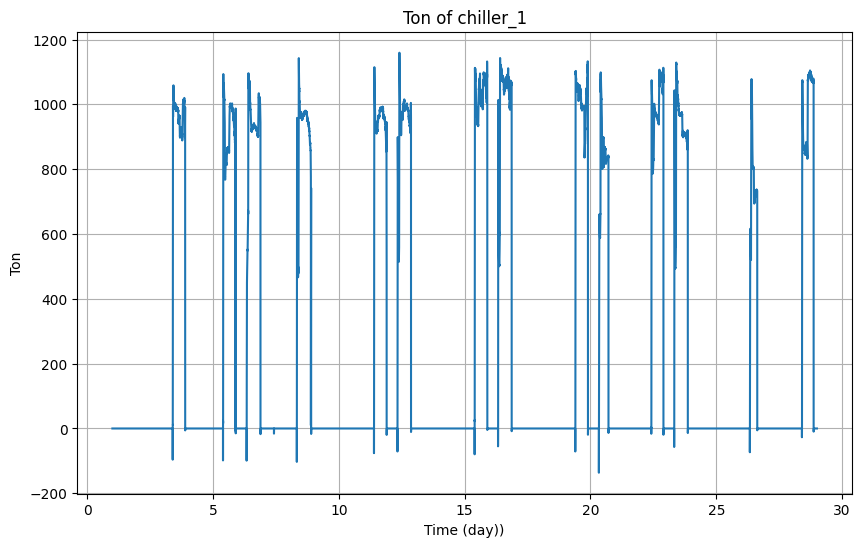

In [5]:
# @title
i_v = 2
i_c = 0

# Ensure processed_times is a numpy array for plotting

processed_times = np.array(processed_times)

# Assuming you want to plot the 'CHR' data (index 3) for the first chiller

var = var_name[i_v]
chiller_name = chillers[i_c]

chiller_1_chr = chiller_data[chiller_name][:, i_v]

# Ensure the data and times have the same length
if len(processed_times) == len(chiller_1_chr):
    plt.figure(figsize=(10, 6)) # Optional: Set the figure size
    plt.plot(processed_times, chiller_1_chr)
    plt.xlabel("Time (day))")
    plt.ylabel(var)
    plt.title(var +" of "+ chiller_name)
    plt.grid(True) # Optional: Add a grid
    plt.show()
else:
    print("Error: The length of processed_times and chiller data do not match.")
    print(f"Length of processed_times: {len(processed_times)}")
    print(f"Length of chiller_1_chr: {len(chiller_1_chr)}")

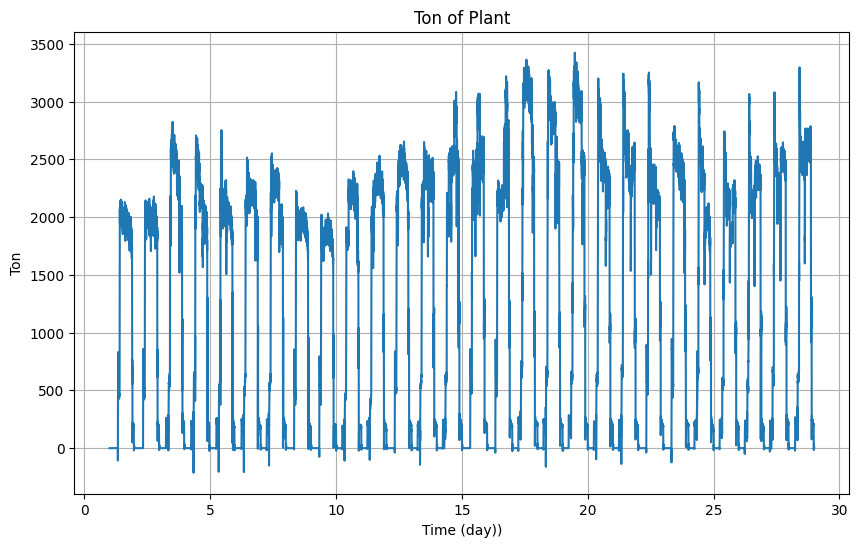

In [6]:
plant_ton = plant_data[:, 0]
if len(processed_times) == len(plant_ton):
    plt.figure(figsize=(10, 6)) # Optional: Set the figure size
    plt.plot(processed_times, plant_ton)
    plt.xlabel("Time (day))")
    plt.ylabel("Ton")
    plt.title("Ton of Plant")
    plt.grid(True) # Optional: Add a grid
    plt.show()


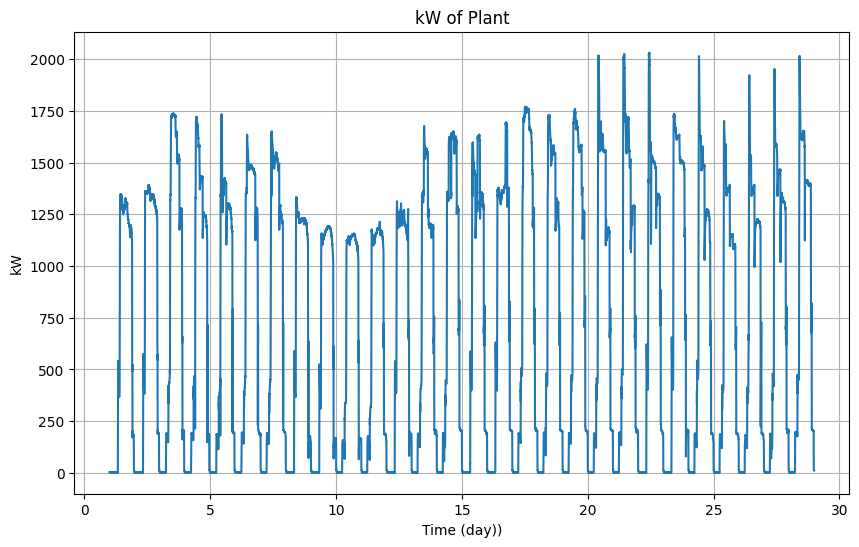

In [7]:
plant_kW = plant_data[:, 1]
if len(processed_times) == len(plant_kW):
    plt.figure(figsize=(10, 6)) # Optional: Set the figure size
    plt.plot(processed_times, plant_kW)
    plt.xlabel("Time (day))")
    plt.ylabel("kW")
    plt.title("kW of Plant")
    plt.grid(True) # Optional: Add a grid
    plt.show()

# **Section 1: Literature Review**

Objective: Demonstrate your understanding of prior work and applicable methods through literature review.

Questions:

● Briefly review several research papers and select 2–5 approaches you think are the
most practical when it comes to real-world implementation for energy-efficient
control in large HVAC or water-cooled chiller plant systems.

● For your literature review, please make a comprehensive comparison and
discussion. This may include
*   Key assumptions and components
*   How would they handle constraints of a chiller plant?
*   Any other aspect worth discussing

### General Key Assumptions
  * The problem want to minimize electric cost and hardware cost of chiller
  * The performance of chiller depend on itself and consistance
  * Recive Demand power of chiller in each time of day

**Note:**

  $\quad t$ index of time

  $\quad i$ index of chiller


## Mix Interger Linear Programing (MILP)
*   **Key Assumpsion**
  *   The Objective function and constant must be formulate as **Linear equation** and the system has static property (the chiller always working well as it was, COP of Chiller remain same)
  $$kW_{it} = a_i+b_iP_{evap,ti}+c_iT_{o,t}$$ calcualtion in [1] show that linear appoximation of power consupsion have value $R^2>0.98$ (Goodness of fit)
$$ \text{Objective Function} = \sum_i \sum_j kW_{it} $$
  * Operating Cost and Turn-on cost is consant
  *   Recive Demand power of chiller in each time of day  
* **How would they handle constraints of a chiller plant?**
  * Power evaporate (Ton) Constraint could be handled by a normal constant, and on-off chiller could handle by binary variable, with specific constraint to be linear function of power evaporate of chiller and slack variable of chiller's status.
  $$g(P_{evap},x) \leq h $$
  $$g_{eq}(P_{evap},x) = h_{eq} $$

*  **Any other aspect worth discussing**
  * The MILP is the most simple method compare to other model optimizaton and its limitaion is unablity to handle complicate system and constrain. However, this simple method provide low cost of computation and less understanding of complicate system.
  * If the system has differnt coffient (COP, operating cost, Turn-on cost) as expected. we could feedback it and update to recalculation at that time or next day.  



## Genetic Algorithm(GA)
*   **Key Assumpsion**
  * The Objective function could be formulated in a complicated function, even **nonlinear**
  $$ kW_{it} = f(P_{evap,it})$$
  Form [2], have relation of power consupsion as
  $$kW_{it} = a_i'+b_i'P_{evap,it}+c_i'P_{evap,it}^2+d_i'P_{evap,it}^3$$
  * The operating variable and chiller cooling power could encode in chromosome structure in GA. [2] represent the chromosome of $P_{evap,it}$ as encoded binary value.
  * The operation of genetic algorthim**(Reproduction,Crossover,Mutation)** could produce better solution in next generation

* **How would they handle constraints of a chiller plant?**
  * [2] handle constraint in form of objective fucntion
  $$ \text{Objective Function} = \text{Objective Function}_0 + \text{Penalty Function} $$
  where the $\text{Penalty Function}$ is fuction that if return high value if the variable is leaked of constraint to converge the solution to feasiable space.
  * For certain constraints in the given problem, we can incorporate the specifications directly into the definition of the chromosome, leading to reduced computational complexity. For example, an on-off constraint can be handled by formulating the chromosome as a list of status values. This allows us to represent the timing of on/off events explicitly, based on assumptions about one-time turns on per day of chiller.
  Example:
  $$S = [0\ 0\ 1\ 1\ 1\ 1\ ....\ 0\ 0]$$
   $$ S = [1\ 2 \ 13] $$
*  **Any other aspect worth discussing**
  * Genetic algorithm (GA) to solve optimal chiller loading (OCL) problem. GA overcomes the flaw that with the Lagrangian method the system may not converge at low demand.[2]
  * The disadvantage of heuristic optimization, like GA, is that it has high computation; however, it can handle complex objective functions and constraints.
  * [3] use GA as initial population for **Grey Wolf Optimizer** and **JAYA algorithm** for specificing in last minimize objective and overcoming convergence issues.

## Partical Swarom Optimization(PSO)
*   **Key Assumpsion**
  * The Objective function could be formulated in a complicated function, even **nonlinear**
  $$ kW_{it} = f(P_{evap,it})$$
  Form [4], have relation of power consupsion as
  $$kW_{it} = a_i'+b_i'P_{evap,it}+c_i'P_{evap,it}^2+d_i'P_{evap,it}^3$$
  Form [5], have relation of power consupsion as
  $$kW_{it} = a_i'+b_i'P_{evap,it}+c_i'P_{evap,it}^2$$
  * The value of variable could be written as space of particle
  * The evolution that references on global best position and the history best psotion lead to conversion of solution of problem.
* **How would they handle constraints of a chiller plant?**
  * Penaty function as GA, if the particle leak from constraints the objective fucntion would increas in large amuont for conversion. [4]
  * Re-initilaize the leaked particle. [4]
*  **Any other aspect worth discussing**
  * PSO has shown effectiveness in both overcoming convergence issues and finding minimum energy solutions [4]

# **Section 2: Problem Formulation**
Objective: Translate the control problem into a formal model-based optimization control problem.

## Questions:
* Define the decision variables, models, objective function, and constraints for this
problem.
* Formulate the problem as a mathematical program (e.g., mixed-integer or
constrained optimization), incorporating the constraints

Optional: Suggest how your formulation might be scalable or generalizable to larger systems.

# Formualte Problem

$$
\min_{\vec{v}, \vec{S}, \vec{P}, \vec{U}} \quad
\text{TOC}^\top \vec{v} + \frac{1}{n} \text{OPC}^\top \vec{S} + \frac{1}{n} (i\text{COP})^\top \vec{P} \\
\begin{aligned}
\text{s.t.} \quad & P_t \preceq P_{\max}, \quad \forall t & \text{Power limitaion of chiller}\\
& \sum_{i=1}^7 P_{i,t} ≥ D_t, \quad \forall t & \text{Demand Met}\\
& U_{i,t} \leq \sum_{k=1}^{T_{min}} S_{i,t+k} & \text{Minimum duration} \\
& U_t \geq 0,\quad \forall t \in [1n,13n]& \text{Chiller turn on in 1:00-12:00}\\
& U_t \leq 0,\quad \forall t \in [13n+1,22n]& \text{Chiller turn on in 12:00-22:00}\\
&\sum_{\tau=t}^{\tau=t+T_{min}} S_{i,\tau} = U_{i,t}*T_{min} & \text{Status and Start indicator relation}\\
& \vec{v}_i \preceq \max(S_i), \quad \forall i & \text{Status in that day and Status relation} \\
& ∑_{t=1}^{n_t}U_i = 0, \quad \forall i & \text{Garuntee On and Off in day} \\
\text{Optional:}\\
\quad & P_t \succeq P_{\min}, \quad \forall t & \text{Minimum Power of chiller}\\
& P_{max}^\top S_{t} < 1.1D_t, \quad \forall t & \text{Reserve Chiller Power}\\
& U_t = 0,\quad \forall t \in \text{Not Avaliable} & \text{Not avaliable on-off Chiller time}\\
\end{aligned}
$$


Not available on-off Chiller time constraint may not be required depending on Demand profile

$T_{min} = 4n$, minumum duration for 4 hours

$\overrightarrow{v}$ is used chiller status in that day, $\overrightarrow{v} \in \mathbb{B}^7$

$S$ is on status of chiller in each time, $S \in \mathbb{B}^{7 \times n_t}$

$U$ is start indicator of chiller in each time, $S \in \{-1,0,1\}^{7 \times n_t}$

$P$ is power evaparate of chiller in each time, $P \in \mathbb{R_+}^{7 \times n_t}$ [ton]

$i\text{COP}$ is invert element wise vector of COP [kW/ton]


$P_{max} = \begin{bmatrix}
 1000&1000  &1000 &1000 &500 &500 &250
\end{bmatrix}^T$ [ton]

$D$ is demand forcast in each time, $D \in \mathbb{R_+}^{ n_t}$ [ton]

$n$ is sampling time per hour

# **Section 3: System Identification**
Objective: Derive models from the provided data that relate control inputs to power
consumption. Below is the explanation of each datapoint in the dataset
- Plant, Ton: The cooling load of the whole building. Represents the cooling demand
required to cool down the indoor space.
- Chiller, CHS: Chilled water supply temperature
- Chiller, CHR: Chilled water supply temperature
- Chiller, CDS: Chilled water supply temperature
- Chiller, CDR: Chilled water supply temperature
Questions:
* Describe your modeling approach. You may use:
  * Thermodynamics models
  * Regression, tree-based models, neural networks, or other ML-based
methods
  * Physical-inspired black-box or gray-box models
* What are the key independent variables / features you used? and how well does
your model perform based on the given data?
* Does your model’s behavior exhibit meaningful physical interpretations? Please
discuss your findings as well. For example, you may discuss on how different
parameters affect the output of the model

$\text{TOC}^\top \vec{v} + \frac{1}{n}\text{OPC}^\top \vec{S} + \frac{1}{n} i\text{COP}^\top \vec{P}$

**What are the key independent variables?**

**Cooling Power of Chiller** $(P_{evap}/\text{ton})$

All of the research we reference says that the power consumption of the chiller depend on the polynomial function of cooling power of chiller. [1], [2], [3] and [4] are spcific that the power consumpsion of chiller could be formulate as cubic equation
 $$kW_{it} = a_i+b_iP_{evap,it}+c_iP_{evap,it}^2+d_iP_{evap,it}^3$$
 However, [1] show that with linear equation ($kW_{it} = a_i+b_iP_{evap,it}$) is enough to identify the system of chiller
So we using linear programming to fit the value of the coefficients in each case:
* Linear Equation: $kW_{it} = a_i+b_iP_{evap,it}$
* Quadatic Equation: $kW_{it} = a_i+b_iP_{evap,it}++c_iP_{evap}^2$
* Cubic Equation: $kW_{it} = a_i+b_iP_{evap,it}+c_iP_{evap,it}^2+d_iP_{evap,it}^3$


## Estimate **Cofficient** form data

Fitted Line: kW = 0.4941 * ton + 97.5980


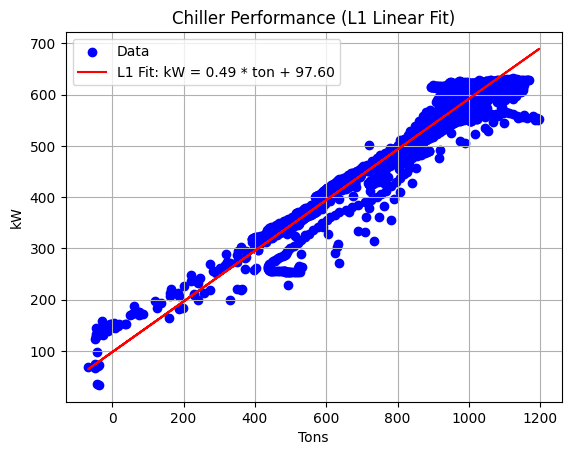

In [8]:
# @title
i =1
ton_i = chiller_data[chillers[i]][:,2]
kW_i = chiller_data[chillers[i]][:,5]
on_i = chiller_data[chillers[i]][:,7]

def on_steady(on, n):
    on = np.asarray(on)
    on_s = np.zeros_like(on)

    for i in range(len(on)):
        if on[i] == 1:
            # Look ahead to i+n (exclusive), safely within bounds
            end_idx = i + n + 1
            if end_idx <= len(on):
                if np.all(on[i:end_idx] == 1):
                    on_s[i] = 1
    return on_s

on_steady_i = on_steady(on_i,240)
ton_i_on = ton_i[on_steady_i==1]
kW_i_on = kW_i[on_steady_i==1]

ton_i_on = ton_i_on[kW_i_on>5]
kW_i_on = kW_i_on[kW_i_on>5]


# L1 loss function: fit y = a * x + b (kW = a * ton + b)

def L1_loss(params, x, y):
    a, b = params
    residuals = y - (b* x + a)
    return np.sum(np.abs(residuals))  # L1 norm

def L2_loss(params, x, y):
    a, b = params
    residuals = y - (b * x + a)
    return np.sum(residuals**2)  # L2 norm (least squares)

# Initial guess for slope and intercept
initial_guess = [1, 0]

# Perform optimization
result = minimize(L1_loss, initial_guess, args=(ton_i_on, kW_i_on), method='Powell')

# Extract fitted parameters
a_fit, b_fit = result.x
print(f'Fitted Line: kW = {b_fit:.4f} * ton + {a_fit:.4f}')

# Plot scatter and fitted line (ton as x, kW as y)
plt.scatter(ton_i_on, kW_i_on, c='b', marker='o', label='Data')
plt.plot(ton_i_on, b_fit * ton_i_on + a_fit, 'r-', label=f'L1 Fit: kW = {b_fit:.2f} * ton + {a_fit:.2f}')
plt.xlabel('Tons')
plt.ylabel('kW')
plt.title('Chiller Performance (L1 Linear Fit)')
plt.grid(True)
plt.legend()
plt.show()


In [9]:
# @title Linear Curve Fit
COP = []
OPC = []
a_lin = []
b_lin = []

for i in range(7):
  ton_i = chiller_data[chillers[i]][:,2]
  kW_i = chiller_data[chillers[i]][:,5]
  on_i = chiller_data[chillers[i]][:,7]


  on_steady_i = on_steady(on_i, 200)
  ton_i_on = ton_i[on_steady_i == 1]
  kW_i_on = kW_i[on_steady_i == 1]

    # Filter where kW_i_on > 5
  ton_i_on = ton_i_on[kW_i_on > 5]
  kW_i_on = kW_i_on[kW_i_on > 5]

    # L1 loss function

    # Initial guess for slope and intercept
  initial_guess = [1, 0]

    # Perform optimization
  result = minimize(L1_loss, initial_guess, args=(ton_i_on, kW_i_on), method='Powell')

    # Extract fitted parameters
  a_fit, b_fit = result.x

    # Push to arrays
  COP.append(1/b_fit)
  OPC.append(a_fit)
  a_lin.append(a_fit)
  b_lin.append(b_fit)

# Convert to numpy arrays if needed
COP = np.array(COP)
OPC = np.array(OPC)
a_lin = np.array(a_lin)
b_lin = np.array(b_lin)

print("a_lin:", a_lin)
print("b_lin:", b_lin)

a_lin: [ 66.36504175  97.72185575  89.99668814  52.85261838  82.69484106
  61.77200787 107.60068989]
b_lin: [0.49499999 0.49288402 0.45626316 0.45875135 0.49717672 0.56548977
 0.17612353]


In [10]:
# @title Quadratic Curve Fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def L1_loss(params, x, y):
    a, b, c = params
    residuals = y - (a + b * x + c * x**2)
    return np.sum(np.abs(residuals))  # L1 norm

def L2_loss(params, x, y):
    a, b, c = params
    residuals = y - (a + b * x + c * x**2)
    return np.sum(residuals**2)  # L2 norm

a_quad = []
b_quad = []
c_quad = []
# Assuming 'chiller_data' and 'chillers' are already defined
for i in range(7):
  ton_i = chiller_data[chillers[i]][:, 2]
  kW_i = chiller_data[chillers[i]][:, 5]
  on_i = chiller_data[chillers[i]][:, 7]

  on_steady_i = on_steady(on_i, 200)
  ton_i_on = ton_i[on_steady_i == 1]
  kW_i_on = kW_i[on_steady_i == 1]

  ton_i_on = ton_i_on[kW_i_on > 5]
  kW_i_on = kW_i_on[kW_i_on > 5]



  # Initial guess: [a, b, c]
  initial_guess = [0, 1, 0]

  # Perform optimization (you can also use L2_loss instead)
  result = minimize(L1_loss, initial_guess, args=(ton_i_on, kW_i_on), method='Powell')

  # Extract fitted parameters
  a_fit, b_fit, c_fit = result.x
  a_quad.append(a_fit)
  b_quad.append(b_fit)
  c_quad.append(c_fit)

# Define quadratic L1 and L2 loss functions


a_quad = np.array(a_quad)
b_quad = np.array(b_quad)
c_quad = np.array(c_quad)

print("a:", a_quad)
print("b:", b_quad)
print("c:", c_quad)


a: [ 151.38928411  -22.6296592   -57.91178992 -109.93041805  101.92442003
   15.47695686   30.15795972]
b: [0.26830008 0.80831542 0.77396087 0.79423715 0.04007997 0.81340139
 0.71839727]
c: [ 0.00014288 -0.00019547 -0.00016767 -0.00017009  0.0009418  -0.00031466
 -0.00088683]


In [11]:
# @title Cubic Curve Fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming 'chiller_data' and 'chillers' are already defined

def L1_loss(params, x, y):
    a, b, c, d = params
    residuals = y - (a + b * x + c * x**2 + d * x**3)
    return np.sum(np.abs(residuals))

def L2_loss(params, x, y):
    a, b, c, d = params
    residuals = y - (a + b * x + c * x**2 + d * x**3)
    return np.sum(residuals**2)
a_cub = []
b_cub = []
c_cub = []
d_cub = []

for i in range(7):
  ton_i = chiller_data[chillers[i]][:, 2]
  kW_i = chiller_data[chillers[i]][:, 5]
  on_i = chiller_data[chillers[i]][:, 7]

  on_steady_i = on_steady(on_i, 200)
  ton_i_on = ton_i[on_steady_i == 1]
  kW_i_on = kW_i[on_steady_i == 1]

  ton_i_on = ton_i_on[kW_i_on > 5]
  kW_i_on = kW_i_on[kW_i_on > 5]

  # Initial guess for [a, b, c, d]
  initial_guess = [0, 1, 0, 0]

  # Perform optimization using L1 loss
  result = minimize(L1_loss, initial_guess, args=(ton_i_on, kW_i_on), method='Powell')

  # Extract fitted parameters
  a_fit, b_fit, c_fit, d_fit = result.x
  a_cub.append(a_fit)
  b_cub.append(b_fit)
  c_cub.append(c_fit)
  d_cub.append(d_fit)
a_cub = np.array(a_cub)
b_cub = np.array(b_cub)
c_cub = np.array(c_cub)
d_cub = np.array(d_cub)

print("a:", a_cub)
print("b:", b_cub)
print("c:", c_cub)
print("d:", d_cub)

a: [137.31295867 105.40765471 118.83240772  87.25143869  98.19902781
  85.77373916 -17.74378537]
b: [0.38482348 0.50304445 0.39023374 0.47980081 0.292337   0.37993626
 0.94338862]
c: [-5.96718808e-05 -6.80862293e-05  2.82747575e-05 -1.60789996e-04
 -1.52505667e-04 -1.04597667e-04 -3.34729727e-04]
d: [ 9.97170653e-08  5.04629066e-08  8.60709140e-09  1.04376787e-07
  1.22472788e-06  8.22877258e-07 -2.66867089e-06]


In [12]:
# @title Coefficient  Table
arrays = [
    ['Linear', 'Linear',
     'Quadratic', 'Quadratic', 'Quadratic',
     'Cubic', 'Cubic', 'Cubic', 'Cubic'],
    ['a', 'b',
     'a', 'b', 'c',
     'a', 'b', 'c', 'd']
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Type", "Coeff"])

# Create DataFrame
df = pd.DataFrame([
    a_lin, b_lin,
    a_quad, b_quad, c_quad,
    a_cub, b_cub, c_cub, d_cub
]).T

df.columns = index
df.index = ['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8']

# Identify the column indices for the last column in each group
linear_b_col_idx = df.columns.get_loc(('Linear', 'b'))
quadratic_c_col_idx = df.columns.get_loc(('Quadratic', 'c'))

# Define the styles as a list of dictionaries
styles = [
    # Style for the header cell under ('Linear', 'b')
    {'selector': f'th.col_heading.level1.col{linear_b_col_idx}',
     'props': [('border-right', '2px solid black')]},
    # Style for the data cells under ('Linear', 'b')
    {'selector': f'td.col{linear_b_col_idx}',
     'props': [('border-right', '2px solid black')]},
    # Style for the header cell under ('Quadratic', 'c')
    {'selector': f'th.col_heading.level1.col{quadratic_c_col_idx}',
     'props': [('border-right', '2px solid black')]},
    # Style for the data cells under ('Quadratic', 'c')
    {'selector': f'td.col{quadratic_c_col_idx}',
     'props': [('border-right', '2px solid black')]}
]

# Apply the styles
styled_df = df.style.set_table_styles(styles)

# Display the styled DataFrame
styled_df

**How well does your model perform based on the given data?**

The overall performance of the chiller modeling can be evaluated using the R² (coefficient of determination) score. From the table, we observe that most chiller models perform well, with $𝑅^2>0.8$, indicating a strong fit between the model predictions and actual data. However, a few chillers exhibit lower performance, suggesting that additional unmodeled variables may influence power consumption in those cases.

Among the models, the quadratic model demonstrates the best overall accuracy. Nonetheless, it underperforms in specific cases in Chiller 8. In some of these, the quadratic model yields negative coefficients or unrealistic behavior, potentially leading to non-physical predictions, such as a chiller turning on without producing cooling.

Given this, the linear model emerges as the most suitable choice for optimization. It offers a good balance between accuracy and robustness, avoids the instability observed in higher-order models, and importantly, requires significantly less computational effort than quadratic or cubic models.

In [13]:
# @title $R^2$ Score Table
from sklearn.metrics import r2_score
import numpy as np

R2_lin = []
R2_quad = []
R2_cub = []

for i in range(7):
    # Extract data
    ton_i = chiller_data[chillers[i]][:, 2]
    kW_i = chiller_data[chillers[i]][:, 5]
    on_i = chiller_data[chillers[i]][:, 7]

    # Steady operation filtering
    on_steady_i = on_steady(on_i, 240)
    ton_i_on = ton_i[on_steady_i == 1]
    kW_i_on = kW_i[on_steady_i == 1]

    # Filter out low power values
    mask = kW_i_on > 5
    ton_i_on = ton_i_on[mask]
    kW_i_on = kW_i_on[mask]

    # --- Linear prediction ---
    pred_lin = a_lin[i] + b_lin[i] * ton_i_on
    R2_lin.append(r2_score(kW_i_on, pred_lin))

    # --- Quadratic prediction ---
    pred_quad = a_quad[i] + b_quad[i] * ton_i_on + c_quad[i] * ton_i_on**2
    R2_quad.append(r2_score(kW_i_on, pred_quad))

    # --- Cubic prediction ---
    pred_cub = (a_cub[i] + b_cub[i] * ton_i_on +
                c_cub[i] * ton_i_on**2 + d_cub[i] * ton_i_on**3)
    R2_cub.append(r2_score(kW_i_on, pred_cub))

# --- Optional: Display all R² scores ---
r2_df = pd.DataFrame({
    'R² Linear': R2_lin,
    'R² Quadratic': R2_quad,
    'R² Cubic': R2_cub
})

r2_df.index = ['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8']

# Display the DataFrame
r2_df


,R² Linear,R² Quadratic,R² Cubic
Chiller1,0.932360,0.940070,0.940490
Chiller2,0.919176,0.894421,0.916957
Chiller3,0.866398,0.836300,0.866366
Chiller4,0.883692,0.842671,0.880435
Chiller6,0.938722,0.959115,0.968722
Chiller7,0.913737,0.877697,0.904412
Chiller8,0.080521,0.493597,-1.517719


Form using linear model, we name coficient to have more physical for understanding

## Estimate **Operating cost** and **COP** form data

From line fitting $kW = a ⋅ton+b$ we could see that
*  $b$ is ${\text{COP}^{-1}} = \frac{Δ\text{kW}}{Δ\text{ton}}$ [kW/ton]
*  $a$ is operating cost or operating power consumpsion when chiller is on [kW]

Furthermore, we assume that turning on a chiller requires an initial amount of power to initiate its operation. To account for this, we define a Turn-On Cost (TOC). This cost reflects the additional energy or operational burden associated with starting a chiller. The TOC can be adjusted to provide flexibility in operation planning—for example, by discouraging frequent daily, thereby promoting more stable and efficient usage patterns.

## Estimate **Turn-On Cost(TOC)** from data

$\text{TOC} =\sum_{}( kW_t- \hat P)/m ,\quad \text{t is all time after status on for n min} $

$\hat P = ton\text{COP}^{-1} + \text{OPC}$

$m$ is status on count of chiller

In [14]:
# @title
TOC = []
def on_transient(on, n):
    on = np.asarray(on)
    on_t = np.zeros_like(on)
    m = 0

    for i in range(1, len(on)):
        if on[i] == 1 and on[i - 1] == 0:
            m += 1
            end_idx = min(i + n, len(on))
            on_t[i:end_idx] = 1

    return on_t, m

for i in range(7):
  COP_i = COP[i]
  OPC_i = OPC[i]
  ton_i = chiller_data[chillers[i]][:,2]
  kW_i = chiller_data[chillers[i]][:,5]
  on_i = chiller_data[chillers[i]][:,7]



  on_transient_i, m = on_transient(on_i, 4)
  ton_i_on = ton_i[on_transient_i==1]
  kW_i_on = kW_i[on_transient_i==1]

  p_ex = ton_i_on/COP_i + OPC_i #power expected
  TOC_i = np.sum(kW_i_on-p_ex) / m/60 #kWhr
  TOC.append(TOC_i)

TOC = np.array(TOC)
TOC = np.maximum(TOC, 0.5000)
print("TOC:", TOC)

TOC: [3.2217003  1.41742937 1.17621514 2.11068967 0.59119538 0.86668812
 0.5       ]


In [15]:
# @title
data = {
    'COP[Ton/kWmin]': COP,
    'OPC[kW]': OPC,
    'TOC[kWhr]': TOC
}

df = pd.DataFrame(data, chillers)

# Plot heatmap as a table
# plt.figure(figsize=(6, 4))
#sns.heatmap(df, annot=True, fmt=".3f", cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')

#plt.title('')
#plt.yticks(rotation=0)
#plt.xticks(rotation=0)
#plt.tight_layout()
#plt.show()
df

,COP[Ton/kWmin],OPC[kW],TOC[kWhr]
chiller_1,2.020202,66.365042,3.221700
chiller_2,2.028875,97.721856,1.417429
chiller_3,2.191718,89.996688,1.176215
chiller_4,2.179830,52.852618,2.110690
chiller_6,2.011357,82.694841,0.591195
chiller_7,1.768379,61.772008,0.866688
chiller_8,5.677833,107.600690,0.500000


# **Section 4: Result Analysis & Baseline Comparison**
Objective: Apply your model to solve for the optimal control decisions for the given dataset
and compare the result with the actual controls in the dataset. Also, it would be helpful if
you can estimate the potential energy savings from applying your control algorithm.

Questions:
* Using your model and controller, simulate the chiller plant operation using the given
historical dataset. Show power consumption, CHS trends, and other important
activities.
* Compare with a baseline strategy, as attached in the data set:
* Discuss:
  * Potential energy savings (absolute or percentage)
  * Any observed trade-offs or limitations

Optional: Suggest how this strategy could extend to real-time MPC deployment.

In [16]:
iCOP = 1./COP
n_chillers = 7
sam_per_hour = 2
n_t = 24 * sam_per_hour

# Example input parameters
P_max = np.array([1000, 1000, 1000, 1000, 500, 500, 250])
P_min = P_max*0.5 #Optional
T_min = 6 *sam_per_hour

S = cp.Variable((n_chillers, n_t), boolean=True)      # ON status
P = cp.Variable((n_chillers, n_t))                    # Power use
U = cp.Variable((n_chillers, n_t))                    # Start/Stop indicator
v = cp.Variable(n_chillers, boolean=True)             # Daily status

## Simulate the chiller plant operation

### Simulation with demand of day 1 data (Example)

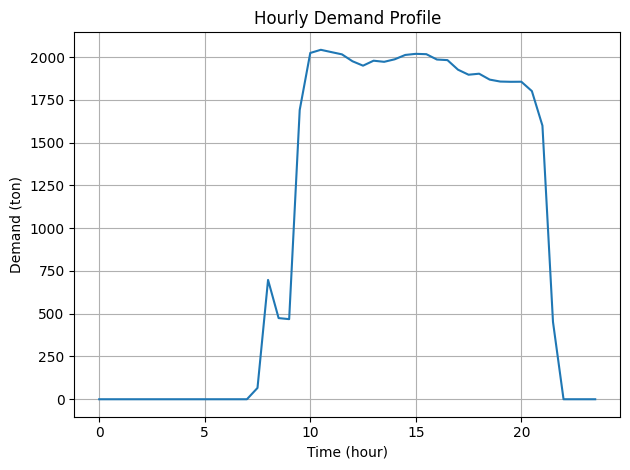

In [17]:
# @title
D1 = plant_ton[0:24*60]  # Ensure it's 1440 elements long
D1[22*60:24*60] = 0
D1 = np.array(D1)        # In case it's not a NumPy array yet

# Reshape to 24 rows of 60 columns each and take mean along axis 1
D1_sam_down = D1.reshape(24*sam_per_hour, 60//sam_per_hour).mean(axis=1)
D =D1_sam_down
plt.plot(np.arange(0, 24, 1/sam_per_hour),D)
plt.xlabel('Time (hour)')
plt.ylabel('Demand (ton)')
plt.title('Hourly Demand Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# @title
constraints = []

# Power limits and linking S to P
for i in range(n_chillers):
    for t in range(n_t):
        constraints += [
            P[i, t] <= P_max[i] * S[i, t],
            P[i, t] >= P_min[i] * S[i, t]
        ]

# Demand satisfaction
for t in range(n_t):
    constraints += [
        cp.sum(P[:, t]) >= D[t],
        cp.sum(cp.multiply(P_max, S[:, t])) >= 1.1 * D[t]  # Reserve constraint
    ]

# Startup/shutdown indicator
for i in range(n_chillers):
    for t in range(1, n_t):
        constraints += [
            U[i, t] == S[i, t] - S[i, t - 1]
        ]
    constraints += [
        U[i, 0] == S[i, 0]
    ]

# Link daily status v
for i in range(n_chillers):
    for t in range(n_t):
        constraints += [
            v[i] >= S[i, t]
        ]

# Time window for turning on/off (optional)
for t in range(n_t):
    if 1*sam_per_hour <= t <= 12*sam_per_hour:
        constraints += [U[:, t] >= 0]  # can turn on
    if 12*sam_per_hour+1 <= t <= 22*sam_per_hour:
        constraints += [U[:, t] <= 0]  # can turn off

# Minimum ON duration
for i in range(n_chillers):
    for t in range(n_t - T_min):
        constraints += [
            cp.sum(S[i, t+1:t+1+T_min]) >= T_min * U[i, t+1]
        ]
constraints += [cp.sum(U) == 0]


Status: optimal
Optimal cost (kWhr): 13436.411594406385
Chiller use (v): [0. 0. 1. 1. 0. 0. 1.]


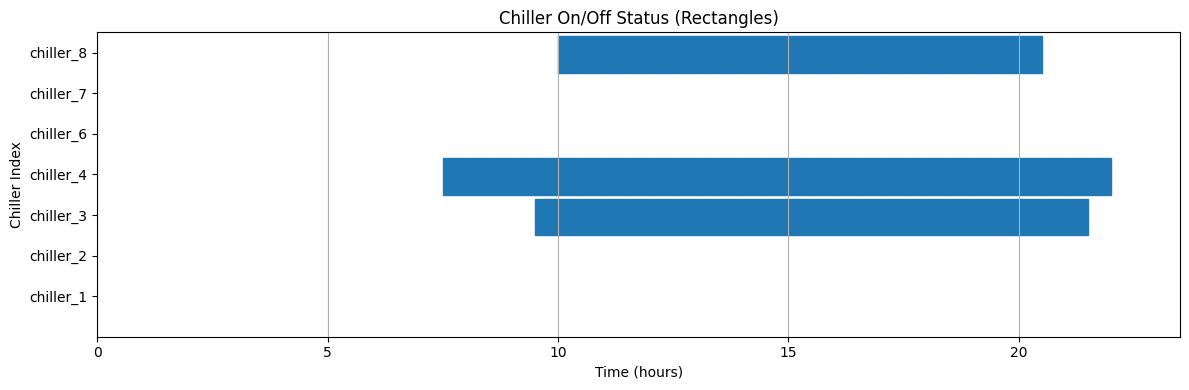

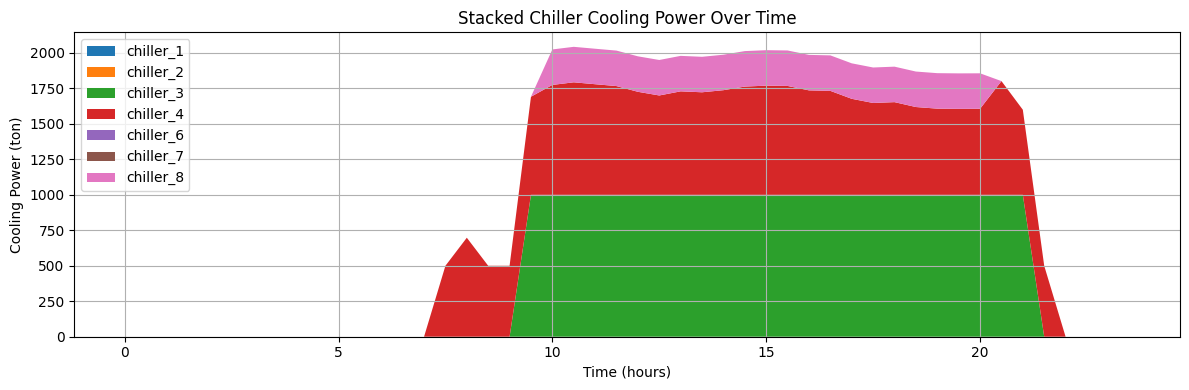

In [19]:
# @title
iCOP_matrix = np.tile(iCOP.reshape(-1, 1), (1, n_t))
OPC_matrix = np.tile(OPC.reshape(-1, 1), (1, n_t))

objective = cp.Minimize(TOC @ v + cp.sum(cp.multiply(OPC_matrix, S))/sam_per_hour + cp.sum(cp.multiply(iCOP_matrix, P))/sam_per_hour)

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GLPK_MI)

print("Status:", prob.status)
print("Optimal cost (kWhr):", prob.value)
print("Chiller use (v):", v.value)

# Ensure data is NumPy arrays
S_val = np.array(S.value)
P_val = np.array(P.value)
n_chillers, n_t = S_val.shape
time = np.arange(n_t) / sam_per_hour  # Convert to hours
width = 1 / sam_per_hour
import matplotlib.patches as patches

# --- Plot 1: Chiller Status as Rectangles ---
plt.figure(figsize=(12, 4))
ax = plt.gca()
for i in range(n_chillers):
    for t in range(n_t):
        if S_val[i, t] == 1:
            rect = patches.Rectangle(
            (time[t], i),  # (x, y)
            1 / sam_per_hour,  # width in hours
            0.9,
            color='tab:blue'
        )
            ax.add_patch(rect)

ax.set_xlim([0, time[-1]])
ax.set_ylim([-0.5, n_chillers])
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Chiller Index')
ax.set_yticks(np.arange(n_chillers) + 0.5)
ax.set_yticklabels(chillers)
ax.set_title('Chiller On/Off Status (Rectangles)')
ax.grid(True, axis='x')
plt.tight_layout()
plt.show()


# --- Plot 2: Stacked Power Usage
plt.figure(figsize=(12, 4))
plt.stackplot(time, P_val, labels=chillers)
plt.xlabel('Time (hours)')
plt.ylabel('Cooling Power (ton)')
plt.title('Stacked Chiller Cooling Power Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



### Simulation with demand of day 16 data (Example)

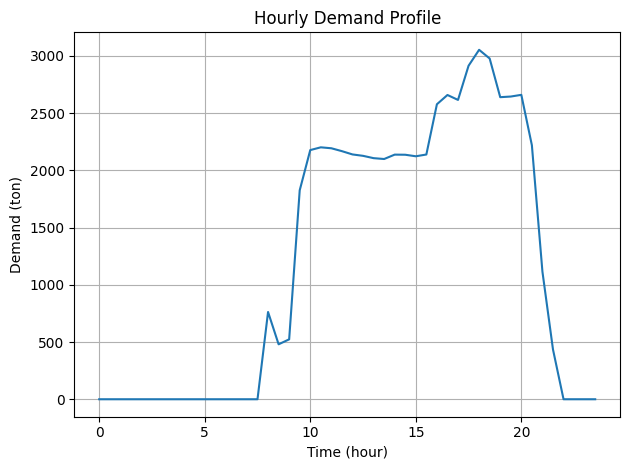

In [20]:
# @title
D2 = plant_ton[15*24*60:16*24*60]  # Ensure it's 1440 elements long
D2[22*60:24*60] = 0
D2 = np.array(D2)        # In case it's not a NumPy array yet
# Reshape to 24 rows of 60 columns each and take mean along axis 1
D2_sam_down = D2.reshape(24*sam_per_hour, 60//sam_per_hour).mean(axis=1)
D2_sam_down = np.where(D2_sam_down < 50, 0, D2_sam_down)
D =D2_sam_down
plt.plot(np.arange(0, 24, 1/sam_per_hour),D)
plt.xlabel('Time (hour)')
plt.ylabel('Demand (ton)')
plt.title('Hourly Demand Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# @title
constraints = []

# Power limits and linking S to P
for i in range(n_chillers):
    for t in range(n_t):
        constraints += [
            P[i, t] <= P_max[i] * S[i, t],
            P[i, t] >= P_min[i] * S[i, t]
        ]

# Demand satisfaction
for t in range(n_t):
    constraints += [
        cp.sum(P[:, t]) >= D[t],
        cp.sum(cp.multiply(P_max, S[:, t])) >= 1.1 * D[t]  # Reserve constraint
    ]

# Startup/shutdown indicator
for i in range(n_chillers):
    for t in range(1, n_t):
        constraints += [
            U[i, t] == S[i, t] - S[i, t - 1]
        ]
    constraints += [
        U[i, 0] == S[i, 0]
    ]

# Link daily status v
for i in range(n_chillers):
    for t in range(n_t):
        constraints += [
            v[i] >= S[i, t]
        ]

# Time window for turning on/off (optional)
for t in range(n_t):
    if 1*sam_per_hour <= t <= 12*sam_per_hour:
        constraints += [U[:, t] >= 0]  # can turn on
    if 12*sam_per_hour+1 <= t <= 22*sam_per_hour:
        constraints += [U[:, t] <= 0]  # can turn off

# Minimum ON duration
for i in range(n_chillers):
    for t in range(n_t - T_min):
        constraints += [
            cp.sum(S[i, t+1:t+1+T_min]) >= T_min * U[i, t+1]
        ]
constraints += [cp.sum(U) == 0]


Status: optimal
Optimal cost (kWhr): 16692.50360436922
Chiller use (v): [1. 0. 1. 1. 0. 1. 0.]


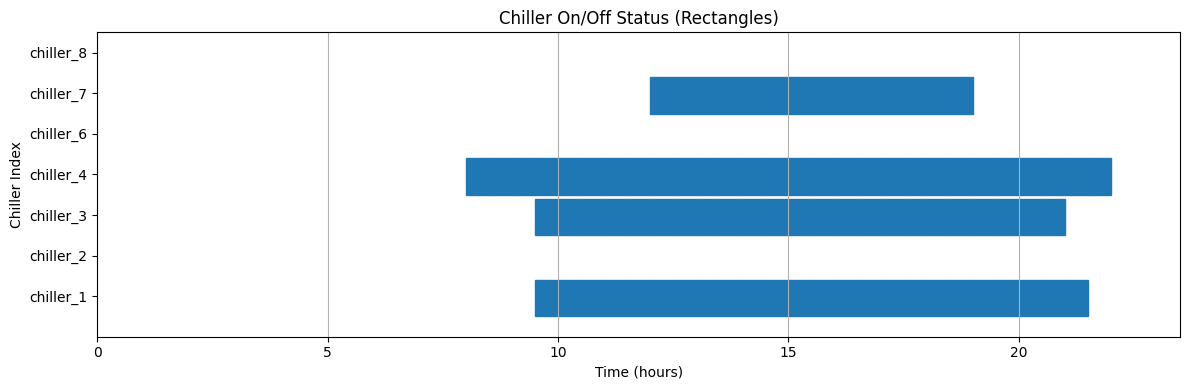

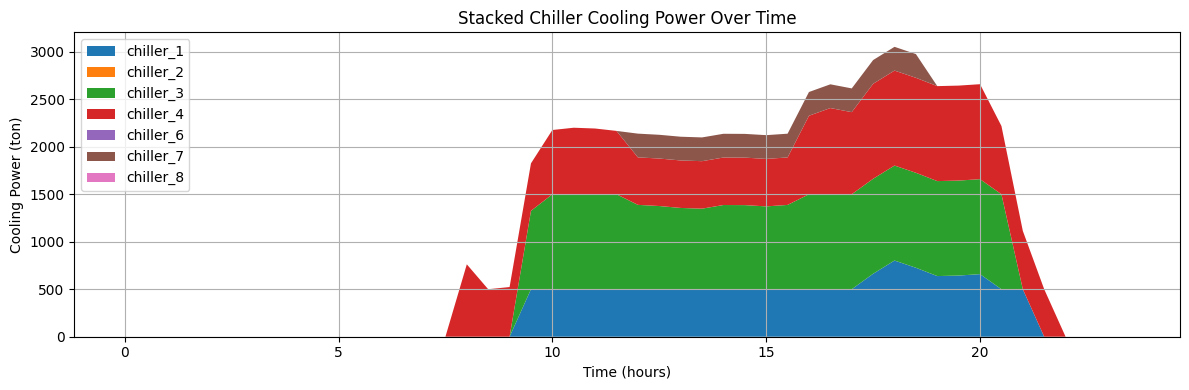

In [22]:
# @title
iCOP_matrix = np.tile(iCOP.reshape(-1, 1), (1, n_t))
OPC_matrix = np.tile(OPC.reshape(-1, 1), (1, n_t))

objective = cp.Minimize(TOC @ v + cp.sum(cp.multiply(OPC_matrix, S))/sam_per_hour + cp.sum(cp.multiply(iCOP_matrix, P))/sam_per_hour)

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GLPK_MI)

print("Status:", prob.status)
print("Optimal cost (kWhr):", prob.value)
print("Chiller use (v):", v.value)

# Ensure data is NumPy arrays
S_val = np.array(S.value)
P_val = np.array(P.value)
n_chillers, n_t = S_val.shape
time = np.arange(n_t) / sam_per_hour  # Convert to hours
width = 1 / sam_per_hour
import matplotlib.patches as patches

# --- Plot 1: Chiller Status as Rectangles ---
plt.figure(figsize=(12, 4))
ax = plt.gca()
for i in range(n_chillers):
    for t in range(n_t):
        if S_val[i, t] == 1:
            rect = patches.Rectangle(
            (time[t], i),  # (x, y)
            1 / sam_per_hour,  # width in hours
            0.9,
            color='tab:blue'
        )
            ax.add_patch(rect)

ax.set_xlim([0, time[-1]])
ax.set_ylim([-0.5, n_chillers])
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Chiller Index')
ax.set_yticks(np.arange(n_chillers) + 0.5)
ax.set_yticklabels(chillers)
ax.set_title('Chiller On/Off Status (Rectangles)')
ax.grid(True, axis='x')
plt.tight_layout()
plt.show()


# --- Plot 2: Stacked Power Usage
plt.figure(figsize=(12, 4))
plt.stackplot(time, P_val, labels=chillers)
plt.xlabel('Time (hours)')
plt.ylabel('Cooling Power (ton)')
plt.title('Stacked Chiller Cooling Power Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:
def MILP_chiller_problem(D,sam_per_hour):
  iCOP = 1./COP
  n_chillers = 7
  n_t = 24 * sam_per_hour

  # Example input parameters
  P_max = np.array([1000, 1000, 1000, 1000, 500, 500, 250])
  P_min = P_max*0.4 #Optional
  T_min = 4 *sam_per_hour

  S = cp.Variable((n_chillers, n_t), boolean=True)      # ON status
  P = cp.Variable((n_chillers, n_t))                    # Power use
  U = cp.Variable((n_chillers, n_t))                    # Start/Stop indicator
  v = cp.Variable(n_chillers, boolean=True)             # Daily status
  '''
  plt.plot(np.arange(0, 24, 1/sam_per_hour),D)
  plt.xlabel('Time (hour)')
  plt.ylabel('Demand (ton)')
  plt.title('Hourly Demand Profile')
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  '''
  # @title
  constraints = []

  # Power limits and linking S to P
  for i in range(n_chillers):
      for t in range(n_t):
          constraints += [
              P[i, t] <= P_max[i] * S[i, t],
              P[i, t] >= P_min[i] * S[i, t]
          ]

  # Demand satisfaction
  for t in range(n_t):
      constraints += [
          cp.sum(P[:, t]) >= D[t],
          cp.sum(cp.multiply(P_max, S[:, t])) >= 1.1 * D[t]  # Reserve constraint
      ]

  # Startup/shutdown indicator
  for i in range(n_chillers):
      for t in range(1, n_t):
          constraints += [
              U[i, t] == S[i, t] - S[i, t - 1]
          ]
      constraints += [
          U[i, 0] == S[i, 0]
      ]

  # Link daily status v
  for i in range(n_chillers):
      for t in range(n_t):
          constraints += [
              v[i] >= S[i, t]
          ]

  # Time window for turning on/off (optional)
  for t in range(n_t):
      if 1*sam_per_hour <= t <= 12*sam_per_hour:
          constraints += [U[:, t] >= 0]  # can turn on
      if 12*sam_per_hour+1 <= t <= 22*sam_per_hour:
          constraints += [U[:, t] <= 0]  # can turn off

  # Minimum ON duration
  for i in range(n_chillers):
      for t in range(n_t - T_min):
          constraints += [
              cp.sum(S[i, t+1:t+1+T_min]) >= T_min * U[i, t+1]
          ]
  constraints += [cp.sum(U) == 0]

  # @title
  iCOP_matrix = np.tile(iCOP.reshape(-1, 1), (1, n_t))
  OPC_matrix = np.tile(OPC.reshape(-1, 1), (1, n_t))

  objective = cp.Minimize(TOC @ v + cp.sum(cp.multiply(OPC_matrix, S))/sam_per_hour + cp.sum(cp.multiply(iCOP_matrix, P))/sam_per_hour)

  prob = cp.Problem(objective, constraints)
  prob.solve(solver=cp.GLPK_MI)

  print("Status:", prob.status)
  print("Optimal cost (kWhr):", prob.value)
  print("Chiller use (v):", v.value)

  # Ensure data is NumPy arrays
  S_val = np.array(S.value)
  P_val = np.array(P.value)
  n_chillers, n_t = S_val.shape
  time = np.arange(n_t) / sam_per_hour  # Convert to hours
  width = 1 / sam_per_hour
  import matplotlib.patches as patches
  '''
  # --- Plot 1: Chiller Status as Rectangles ---
  plt.figure(figsize=(12, 4))
  ax = plt.gca()
  for i in range(n_chillers):
      for t in range(n_t):
          if S_val[i, t] == 1:
              rect = patches.Rectangle(
              (time[t], i),  # (x, y)
              1 / sam_per_hour,  # width in hours
              0.9,
              color='tab:blue'
          )
              ax.add_patch(rect)

  ax.set_xlim([0, time[-1]])
  ax.set_ylim([-0.5, n_chillers])
  ax.set_xlabel('Time (hours)')
  ax.set_ylabel('Chiller Index')
  ax.set_yticks(np.arange(n_chillers) + 0.5)
  ax.set_yticklabels(chillers)
  ax.set_title('Chiller On/Off Status (Rectangles)')
  ax.grid(True, axis='x')
  plt.tight_layout()
  plt.show()


  # --- Plot 2: Stacked Power Usage
  plt.figure(figsize=(12, 4))
  plt.stackplot(time, P_val, labels=chillers)
  plt.xlabel('Time (hours)')
  plt.ylabel('Cooling Power (ton)')
  plt.title('Stacked Chiller Power Cooling Power Over Time')
  plt.legend(loc='upper left')
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  '''
  return P_val,S_val,v.value, prob.value





In [24]:
def MILP_chiller_problem_n(D,sam_per_hour,TOC_n):
  iCOP = 1./COP
  n_chillers = 7
  n_t = 24 * sam_per_hour

  # Example input parameters
  P_max = np.array([1000, 1000, 1000, 1000, 500, 500, 250])
  P_min = P_max*0.4 #Optional
  T_min = 4 *sam_per_hour

  S = cp.Variable((n_chillers, n_t), boolean=True)      # ON status
  P = cp.Variable((n_chillers, n_t))                    # Power use
  U = cp.Variable((n_chillers, n_t))                    # Start/Stop indicator
  v = cp.Variable(n_chillers, boolean=True)             # Daily status
  '''
  plt.plot(np.arange(0, 24, 1/sam_per_hour),D)
  plt.xlabel('Time (hour)')
  plt.ylabel('Demand (ton)')
  plt.title('Hourly Demand Profile')
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  '''
  # @title
  constraints = []

  # Power limits and linking S to P
  for i in range(n_chillers):
      for t in range(n_t):
          constraints += [
              P[i, t] <= P_max[i] * S[i, t],
              P[i, t] >= P_min[i] * S[i, t]
          ]

  # Demand satisfaction
  for t in range(n_t):
      constraints += [
          cp.sum(P[:, t]) >= D[t],
          cp.sum(cp.multiply(P_max, S[:, t])) >= 1.1 * D[t]  # Reserve constraint
      ]

  # Startup/shutdown indicator
  for i in range(n_chillers):
      for t in range(1, n_t):
          constraints += [
              U[i, t] == S[i, t] - S[i, t - 1]
          ]
      constraints += [
          U[i, 0] == S[i, 0]
      ]

  # Link daily status v
  for i in range(n_chillers):
      for t in range(n_t):
          constraints += [
              v[i] >= S[i, t]
          ]

  # Time window for turning on/off (optional)
  for t in range(n_t):
      if 1*sam_per_hour <= t <= 12*sam_per_hour:
          constraints += [U[:, t] >= 0]  # can turn on
      if 12*sam_per_hour+1 <= t <= 22*sam_per_hour:
          constraints += [U[:, t] <= 0]  # can turn off

  # Minimum ON duration
  for i in range(n_chillers):
      for t in range(n_t - T_min):
          constraints += [
              cp.sum(S[i, t+1:t+1+T_min]) >= T_min * U[i, t+1]
          ]
  constraints += [cp.sum(U) == 0]

  # @title
  iCOP_matrix = np.tile(iCOP.reshape(-1, 1), (1, n_t))
  OPC_matrix = np.tile(OPC.reshape(-1, 1), (1, n_t))

  objective = cp.Minimize(TOC_n @ v + cp.sum(cp.multiply(OPC_matrix, S))/sam_per_hour + cp.sum(cp.multiply(iCOP_matrix, P))/sam_per_hour)

  prob = cp.Problem(objective, constraints)
  prob.solve(solver=cp.GLPK_MI)

  print("Status:", prob.status)
  print("Optimal cost (kWhr):", prob.value)
  print("Chiller use (v):", v.value)

  # Ensure data is NumPy arrays
  S_val = np.array(S.value)
  P_val = np.array(P.value)
  n_chillers, n_t = S_val.shape
  time = np.arange(n_t) / sam_per_hour  # Convert to hours
  width = 1 / sam_per_hour

  return P_val,S_val,v.value, prob.value





In [25]:
from IPython.display import clear_output
#Short Command for calling Problem Solver
# D_sam_down is array have 24*sample_per_hour element
MILP_chiller_problem_n(D1_sam_down,sam_per_hour,TOC)
clear_output()

In [26]:
D_dict = dict()

for d in range(28):
  D = plant_ton[d*24*60:(d+1)*24*60]  # Ensure it's 1440 elements long
  D[22*60:24*60] = 0
  D[0*60:1*60] = 0
  D = np.array(D)        # In case it's not a NumPy array yet
  # Reshape to 24 rows of 60 columns each and take mean along axis 1
  D_sam_down = D.reshape(24*sam_per_hour, 60//sam_per_hour).mean(axis=1)
  D_sam_down = np.where(D_sam_down < 50, 0, D_sam_down)
  D =D_sam_down
  D_dict[d] = D

In [27]:
# @title
P_sim_dict = {}
S_sim_dict = {}
v_sim_dict = {}
cost_sim_dict = {}

P_baseline_dict = {}
S_baseline_dict = {}

allday = 28

for d in range(allday):
    print(f"Day {d+1}")

    # -- Input data for this day
    D = D_dict[d]  # demand input for day d
    P_sim, S_sim, v_sim, cost_sim = MILP_chiller_problem(D, sam_per_hour)

    # Store MILP results
    P_sim_dict[d] = P_sim
    S_sim_dict[d] = S_sim
    v_sim_dict[d] = v_sim
    cost_sim_dict[d] = cost_sim

    # Get actual (baseline) data from chiller logs
    P_actual = np.zeros_like(P_sim)
    S_actual = np.zeros_like(S_sim)

    for i in range(7):
        ton_i = chiller_data[chillers[i]][:, 2]
        kW_i = chiller_data[chillers[i]][:, 5]
        on_i = chiller_data[chillers[i]][:, 7]

        # Get the correct day slice (each day has 24*60 samples)
        ton_day = ton_i[d*24*60:(d+1)*24*60]
        kW_day = kW_i[d*24*60:(d+1)*24*60]
        on_day = on_i[d*24*60:(d+1)*24*60]

        # Downsample to match sam_per_hour
        ton_down = ton_day.reshape(24*sam_per_hour, -1).mean(axis=1)
        kW_down = kW_day.reshape(24*sam_per_hour, -1).mean(axis=1)
        on_down = on_day.reshape(24*sam_per_hour, -1).mean(axis=1)

        P_actual[i, :] = kW_down
        S_actual[i, :] = (on_down > 0.5).astype(int)  # Threshold to binary

    # Store baseline
    P_baseline_dict[d] = P_actual
    S_baseline_dict[d] = S_actual
clear_output()

In [28]:
# @title
energy_sim = []
energy_actual = []

for d in range(allday):
    energy_sim.append(np.sum(cost_sim_dict[d]))
    energy_actual.append(np.sum(P_baseline_dict[d]) / sam_per_hour)

energy_sim = np.array(energy_sim)
energy_actual = np.array(energy_actual)

total_sim = np.sum(energy_sim)
total_actual = np.sum(energy_actual)

energy_saving_kwh = total_actual - total_sim
energy_saving_percent = (energy_saving_kwh / total_actual) * 100


## Potential energy savings (absolute or percentage)

From the energy savings graph, it can be seen that there is a portion of energy that has been successfully conserved. This is because the MILP formulation simplifies the problem in a way that tends to favor the selection of the most efficient chiller. However, there are some days when the energy consumption exceeds the baseline. This may be due to the model being overly simplified, overlooking certain advantages that arise from nonlinear characteristics. Additionally, the inclusion of the energy reserve constraint ($P_{max}^\top S_{t} < 1.1D_t$) may sometimes result in some chillers being activated more than actually necessary.


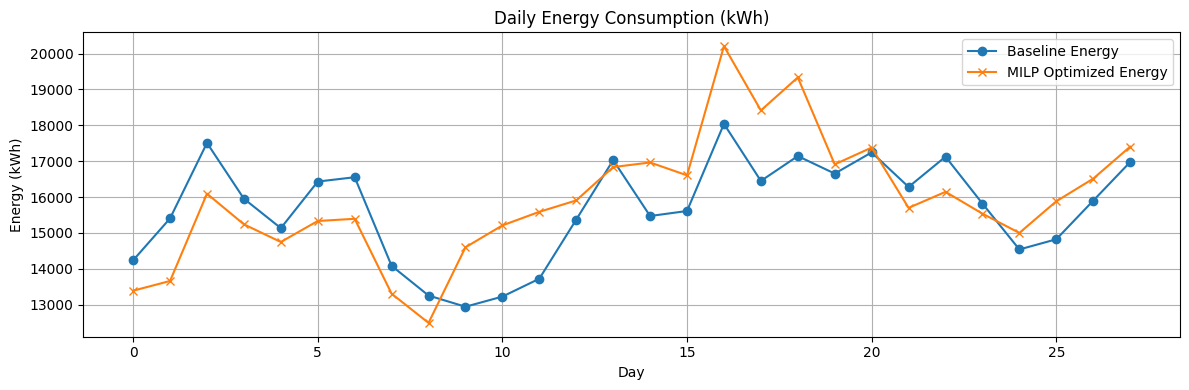

In [29]:
# @title Baseline Energy vs MILP Optimized Energy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(energy_actual, label='Baseline Energy', marker='o')
plt.plot(energy_sim, label='MILP Optimized Energy', marker='x')
plt.title('Daily Energy Consumption (kWh)')
plt.xlabel('Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


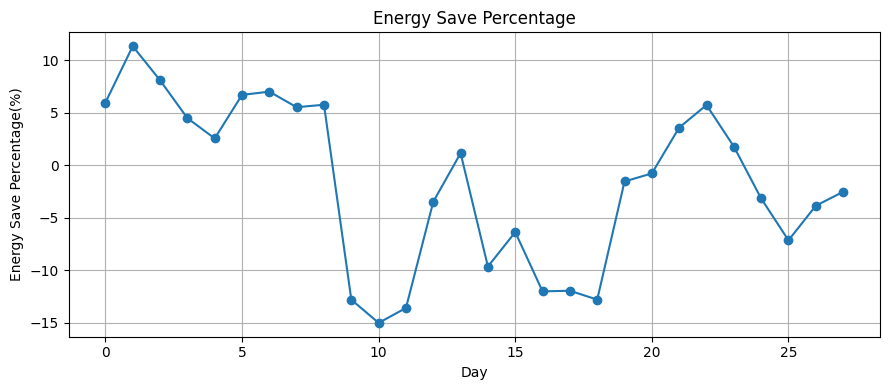

In [30]:
# @title Energy Save Percentage in each day case of Demand
save_per = (energy_actual-energy_sim)/energy_actual*100
plt.figure(figsize=(9, 4))
plt.plot(save_per, marker='o')
plt.title('Energy Save Percentage')
plt.xlabel('Day')
plt.ylabel('Energy Save Percentage(%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Any observed trade-offs or limitations

From monthly simulation, we would see the clear problem that control have tread to chosen the same chiller in eveyday continusly. this tread could casue a problem to damage to the chiller both eveyday active and non-active chiller. So for simply impliaction we could bias TOC value for balance activity in each chiller in monthly simulation.

Due to running the code on Colab, the solver we use is free and may result in slow execution, even though we use a simplified model. However, using a more suitable optimization environment such as MATLAB or other dedicated solvers could provide faster computation. Moreover, by formulating the problem as a Mixed-Integer Linear Programming (MILP) model, we can guarantee that the solution is truly globally optimal, unlike heuristic optimization methods.

### Monthly Simulation

In [31]:
# @title
v_total = np.sum([v_sim_dict[d] for d in range(28)], axis=0)  # shape (7,)

# --- Compute total Energy (P) in kWh ---
energy_total = np.zeros(7)
for d in range(28):
    P_d = P_sim_dict[d]  # shape (7, n_t)
    energy_total += np.sum(P_d, axis=1) / sam_per_hour

v_total_int = np.array(v_total, dtype=int)
energy_total_clean = [0 if e < 1 else e for e in energy_total]

# Create DataFrame
df_summary = pd.DataFrame({
    "Total On-Days": v_total_int,
    "Total Energy (kWh)": energy_total_clean
})
df_summary.index = ['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8']

df_summary

,Total On-Days,Total Energy (kWh)
Chiller1,26,127482.303209
Chiller2,0,0.000000
Chiller3,28,309441.291098
Chiller4,28,297808.631629
Chiller6,0,0.000000
Chiller7,9,11479.920123
Chiller8,21,42651.159697


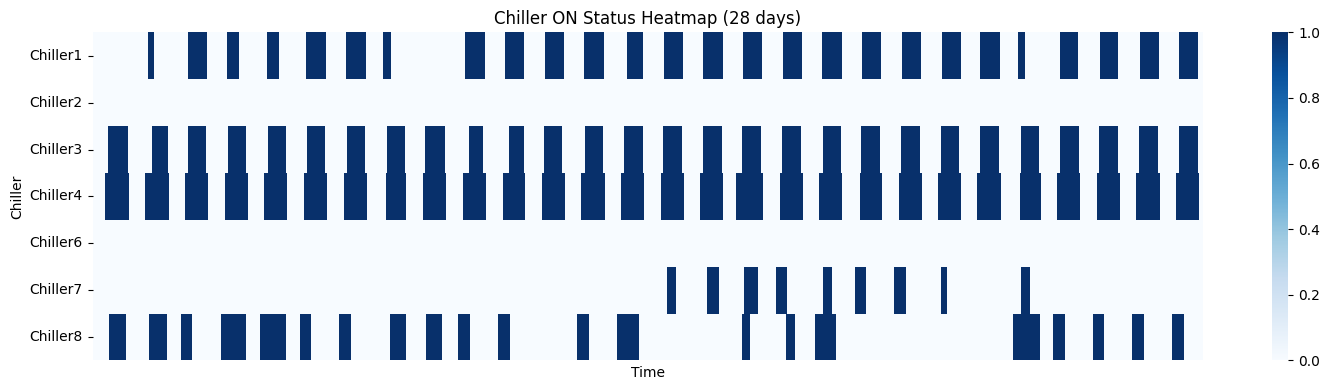

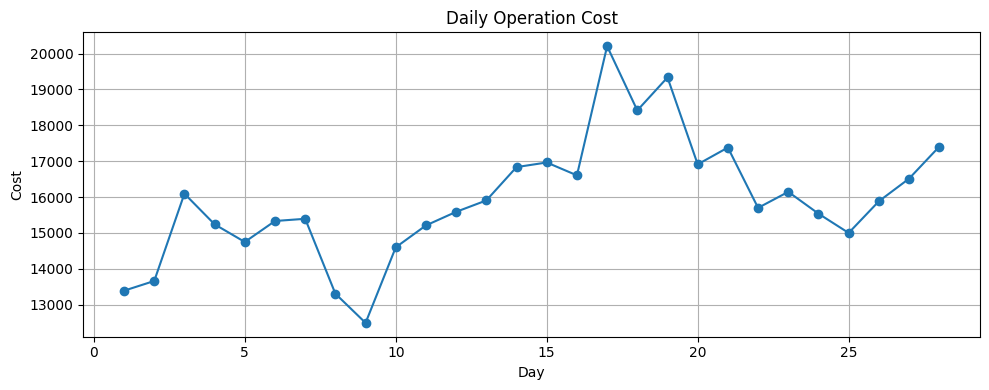

In [32]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot S_dict as heatmap ---
S_stack = np.concatenate([S_sim_dict[d] for d in range(28)], axis=1)  # shape (7, 28*n_t)
plt.figure(figsize=(15, 4))
sns.heatmap(S_stack, cmap="Blues", cbar=True, xticklabels=False, yticklabels=['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8'])
plt.title("Chiller ON Status Heatmap (28 days)")
plt.xlabel("Time")
plt.ylabel("Chiller")
plt.tight_layout()
plt.show()

# --- Plot cost_dict ---
cost_list = [cost_sim_dict[d] for d in range(28)]
plt.figure(figsize=(10, 4))
plt.plot(range(1, 29), cost_list, marker='o')
plt.title("Daily Operation Cost")
plt.xlabel("Day")
plt.ylabel("Cost")
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Simulation with Bias TOC

In [33]:
# @title
v_dict = dict()
P_dict = dict()
S_dict = dict()
cost_dict = dict()
TOC_d = TOC
streak = np.zeros(7, dtype=int)
for d in range(28):
  for i in range(7):
    if streak[i] >= 3:
        TOC_d[i] = TOC[i] + (300 * (streak[i] - 1))  # Increase cost
    elif streak[i] <= -2:
        TOC_d[i] = TOC[i]/abs(streak[i])  # Decrease cost
    else:
        TOC_d[i] = TOC[i]  # Reset to base TOC if no strong bias

  D = D_dict[d]
  print("day",d+1)
  P_d,S_d,v_d, cost_d = MILP_chiller_problem_n(D,sam_per_hour,TOC_d)

  bias_cost = TOC_d @ v_d - TOC @ v_d
  true_cost = cost_d - bias_cost

  v_dict[d] = v_d
  P_dict[d] = P_d
  S_dict[d] = S_d
  cost_dict[d] = true_cost
  for i in range(7):
        if v_d[i] == 1:
            if streak[i] <= 0:
                streak[i] = 1
            else:
                streak[i] = streak[i] + 1
        else:
            if streak[i] >= 0:
                streak[i] = -1
            else:
              streak[i] = streak[i] - 1

day 1
Status: optimal
Optimal cost (kWhr): 13389.388664372353
Chiller use (v): [0. 0. 1. 1. 0. 0. 1.]
day 2
Status: optimal
Optimal cost (kWhr): 13660.29503569852
Chiller use (v): [1. 0. 1. 1. 0. 0. 1.]
day 3
Status: optimal
Optimal cost (kWhr): 16094.511956325994
Chiller use (v): [1. 0. 1. 1. 0. 0. 1.]
day 4
Status: optimal
Optimal cost (kWhr): 16301.806475340149
Chiller use (v): [1. 1. 0. 1. 0. 1. 0.]
day 5
Status: optimal
Optimal cost (kWhr): 16500.76443945699
Chiller use (v): [0. 1. 1. 0. 1. 1. 0.]
day 6
Status: optimal
Optimal cost (kWhr): 17096.087217073822
Chiller use (v): [0. 1. 1. 0. 1. 1. 0.]
day 7
Status: optimal
Optimal cost (kWhr): 16769.44990704239
Chiller use (v): [1. 0. 0. 1. 1. 0. 1.]
day 8
Status: optimal
Optimal cost (kWhr): 15052.380505884506
Chiller use (v): [1. 0. 1. 1. 0. 0. 1.]
day 9
Status: optimal
Optimal cost (kWhr): 13652.050018514408
Chiller use (v): [1. 0. 0. 1. 0. 0. 1.]
day 10
Status: optimal
Optimal cost (kWhr): 16585.591597643797
Chiller use (v): [0. 1

In [34]:
# @title
v_total = np.sum([v_dict[d] for d in range(28)], axis=0)  # shape (7,)

# --- Compute total Energy (P) in kWh ---
energy_total = np.zeros(7)
for d in range(28):
    P_d = P_dict[d]  # shape (7, n_t)
    energy_total += np.sum(P_d, axis=1) / sam_per_hour

v_total_int = np.array(v_total, dtype=int)
energy_total_clean = [0 if e < 1 else e for e in energy_total]

# Create DataFrame
df_summary = pd.DataFrame({
    "Total On-Days": v_total_int,
    "Total Energy (kWh)": energy_total_clean
})
df_summary.index = ['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8']

df_summary

,Total On-Days,Total Energy (kWh)
Chiller1,18,125042.373059
Chiller2,16,124662.567294
Chiller3,19,221122.816134
Chiller4,20,232942.535347
Chiller6,11,13931.726353
Chiller7,14,30933.591132
Chiller8,16,40494.351802


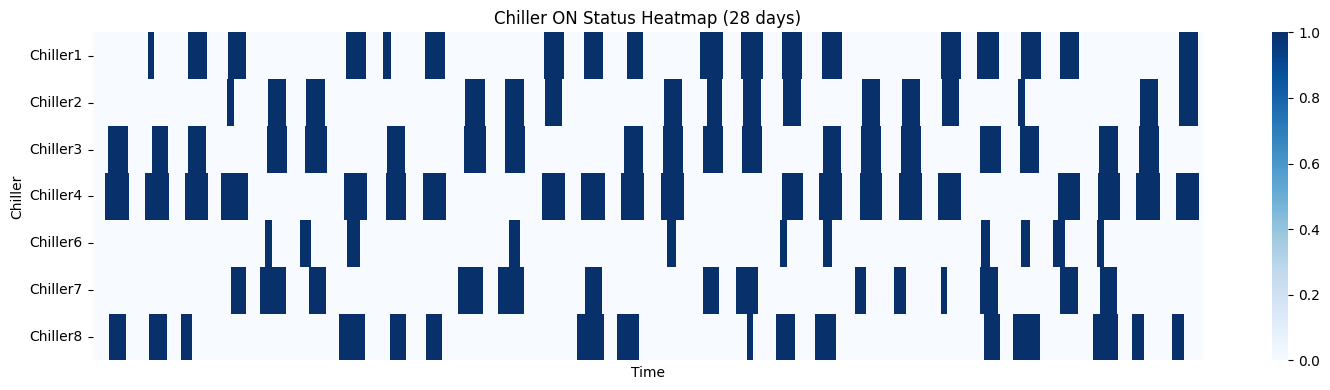

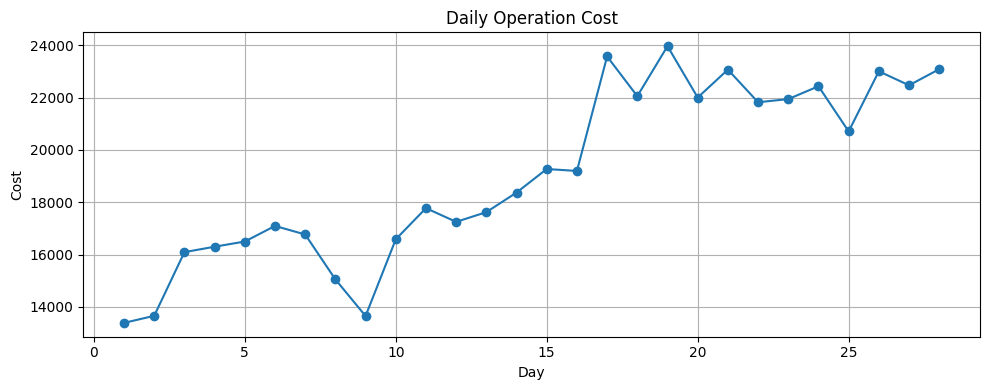

In [35]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot S_dict as heatmap ---
S_stack = np.concatenate([S_dict[d] for d in range(28)], axis=1)  # shape (7, 28*n_t)
plt.figure(figsize=(15, 4))
sns.heatmap(S_stack, cmap="Blues", cbar=True, xticklabels=False, yticklabels=['Chiller1','Chiller2','Chiller3','Chiller4','Chiller6','Chiller7','Chiller8'])
plt.title("Chiller ON Status Heatmap (28 days)")
plt.xlabel("Time")
plt.ylabel("Chiller")
plt.tight_layout()
plt.show()

# --- Plot cost_dict ---
cost_list = [(cost_dict[d]) for d in range(28)]
plt.figure(figsize=(10, 4))
plt.plot(range(1, 29), cost_list, marker='o')
plt.title("Daily Operation Cost")
plt.xlabel("Day")
plt.ylabel("Cost")
plt.grid(True)
plt.tight_layout()
plt.show()

## Strategy could extend to real-time MPC deployment.

Solving a global solution for an MILP problem can require a long computation time. If the optimization is performed hours in advance—such as during the preparation phase the day before—it may not be an issue. However, for real-time control, this computational delay can have a significant impact. One approach to address this challenge is to adjust the sampling time: use a high sampling rate (i.e., higher accuracy) for the near-term horizon, and a lower sampling rate (i.e., lower accuracy) for time steps further in the future. After each optimization cycle and upon receiving updated data, the model should be updated with the most recent information (feedback), allowing it to adjust and improve its accuracy over time.

[1] X. Wei, G. Xu, and A. Kusiak, "Modeling and optimization of a chiller plant," Energy, vol. 73, pp. 898–907, Aug. 2014, doi: 10.1016/j.energy.2014.06.102.


[2] Y.-C. Chang, J.-K. Lin, and M.-H. Chuang, "Optimal chiller loading by genetic algorithm for reducing energy consumption," Energy and Buildings, vol. 37, no. 2, pp. 147–155, Feb. 2005, doi: 10.1016/j.enbuild.2004.06.002.

[3] K. Shejul and R. Harikrishnan, "Energy consumption optimization of chiller plants with the Genetic Algorithm based GWO and JAYA Algorithm in the dynamic pricing Demand Response," Results in Engineering, vol. 22, p. 102193, Jun. 2024, doi: 10.1016/j.rineng.2024.102193.

[4] W.-S. Lee, W.-H. Lin, C.-C. Cheng, and C.-Y. Lin, "Optimal Chiller Loading by Team Particle Swarm Algorithm for Reducing Energy Consumption," Energies, vol. 14, no. 21, p. 7066, Oct. 2021, doi: 10.3390/en14217066.

[5] J. H. Cha, J. Park, S. H. Yeon, Y. Yoon, and K. H. Lee, "Particle Swarm Optimization for multi-chiller system: Capacity configuration and load distribution," Journal of Building Engineering, vol. 98, p. 110953, Dec. 2024, doi: 10.1016/j.jobe.2024.110953.

